In [1]:
import os 
import pandas as pd
import glob 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np

os.chdir('/mnt/BioHome/jreyna/jreyna/projects/dchallenge/')

outdir = 'results/notebooks/colocalization_with_eqtl_catalogue/'
os.makedirs(outdir, exist_ok=True)

In [2]:
# load gwas meta-data
gwas_meta = pd.read_table('config/gwas.samplesheet.tsv')
gwas_meta.set_index('gwas_id', inplace=True)

## Loading the GENCODE Reference

In [3]:
gencode = pd.read_table('results/refs/gencode/v30/gencode.v30.annotation.bed', header=None)
gencode = gencode.iloc[:, [5,6]]
gencode.set_index(6, inplace=True)
gencode = gencode.squeeze()
gencode = gencode.to_dict()
rev_gencode = {v:k for k,v in gencode.items()}

## Loading and Processing the Colocalization Data 

In [4]:
data = []
coloc_glob = 'results/main/coloc/Results/eQTL_Catalogue/*/*/*/FINAL_Summary_Coloc_Gene_SNP_Pairs.bed'
coloc_fns = sorted(glob.glob(coloc_glob))
coloc_fns = [x for x in coloc_fns if 'test' not in x]
print('Number of colocalizations analyses: {}.'.format(len(coloc_fns)))

Number of colocalizations analyses: 78.


In [5]:
for fn in coloc_fns:
    
    # load the data
    df = pd.read_table(fn)
    
    # get GWAS, eQTL and gene expression sources
    fname_segs = fn.split('/')
    gwas = fname_segs[5]
    eqtl = fname_segs[6]
    ge = fname_segs[7]
    
    # assign the current values
    df['gwas'] = gwas
    df['eqtl'] = eqtl
    df['ge'] = ge
    data.append(df)
    
t1d_data = pd.concat(data)

In [6]:
# add the gene name
t1d_data['gene_name'] = t1d_data.geneName.replace(rev_gencode)

In [7]:
# removing duplicate SNP-gene pairs by find the one with the largest PP4
t1d_data_rgs = t1d_data.groupby(['gwas', 'eqtl', 'ge', 'rs_id', 'geneName'])
new_t1d_data = []
for grp, grp_df in t1d_data_rgs:
    max_index = np.argmax(grp_df.pp_H4_Coloc_Summary)
    new_t1d = grp_df.iloc[max_index,:]
    new_t1d_data.append(new_t1d)
new_t1d_data = pd.DataFrame(new_t1d_data)
new_t1d_data.reset_index(drop=True, inplace=True)

# assigning t1d_data to the new dataset
t1d_data = new_t1d_data.copy()

In [8]:
# creating a list of the most important columns 
major_cols = ['chr', 'pos','rs_id', 'variant_id', 'gene_name','pp_H4_Coloc_Summary', 'dist', 'pvalue', 'FDR', 'slope_snp',
       'slope_se_snp', 'slope_gwas', 'slope_se_gwas', 'pval_nominal', 'SampleSize', 'gwas', 'eqtl', 'ge',
       'geneName']

# generating a dataframe the the most important columns
t1d_data = t1d_data[major_cols]

# renaming these columns for easier understanding
major_renames = {
    'chr': 'chr',
    'pos': 'pos',
    'rs_id': 'rsid',
    'variant_id': 'varid',
    'gene_name': 'genename',
    'pp_H4_Coloc_Summary': 'ppH4',
    'dist': 'sg_dist',
    'pvalue': 'eqtl_pval',
    'FDR': 'eqtl_fdr',
    'slope_snp': 'eqtl_slope',
    'slope_se_snp': 'eqtl_slope_se',
    'slope_gwas': 'gwas_slope',
    'slope_se_gwas': 'gwas_slope_se',
    'pval_nominal': 'gwas_pval',
    'SampleSize': 'gwas_sample_size',
    'gwas': 'gwas_source',
    'eqtl': 'eqtl_source',
    'ge': 'ge_source',
    'geneName': 'gene_id'}
major_cols = [major_renames[x] for x in major_cols]
t1d_data.rename(columns=major_renames, inplace=True)

### Checking Colocalized SNPs with Significant eQTLs (FDR<0.05)

In [9]:
sig_eqtls = t1d_data[major_cols].\
                        sort_values(['gwas_source', 'eqtl_source', 'ge_source', 'rsid']).\
                        set_index(['gwas_source', 'ge_source', 'rsid'])
sig_eqtls = sig_eqtls[sig_eqtls.eqtl_fdr < 0.05]

In [10]:
sig_eqtls

chr  \
gwas_source               ge_source                rsid                
T1D_25751624              T-cell                   rs639575     chr6   
                          LCL                      rs1788097   chr18   
                          T-cell                   rs1788097   chr18   
                                                   rs9981624   chr21   
                          LCL                      rs1790932   chr18   
                          blood                    rs9981624   chr21   
                                                   rs11203202  chr21   
                          monocyte_IAV             rs1790932   chr18   
                          monocyte_LPS             rs9388489    chr6   
                          monocyte_R848            rs17207042  chr18   
                                                   rs9375435    chr6   
                          CD4_T-cell_anti-CD3-CD28 rs1615504   chr18   
                          CD4_T-cell_naive         rs9981624   chr21   
                          CD8_T-cell_anti-CD3-CD28 rs1865761   chr18   
                          Tfh_memory               rs9388494    chr6   
                                                   rs9981624   chr21   
                          Th1-17_memory            rs763361    chr18   
                          Th17_memory              rs763361    chr18   
                          Th1_memory               rs1788097   chr18   
                          Treg_memory              rs3018275   chr18   
                          Treg_naive               rs3018275   chr18   
T1D_32005708              monocyte                 rs10876864  chr12   
                          neutrophil               rs10876864  chr12   
                          LCL                      rs1131017   chr12   
                          T-cell                   rs1131017   chr12   
                          blood                    rs1131017   chr12   
                          pancreas                 rs1131017   chr12   
                          B-cell_naive             rs1131017   chr12   
                          CD4_T-cell_anti-CD3-CD28 rs1131017   chr12   
                          CD8_T-cell_anti-CD3-CD28 rs1131017   chr12   
                          NK-cell_naive            rs1131017   chr12   
                          Th1-17_memory            rs1131017   chr12   
                          monocyte_CD16_naive      rs1131017   chr12   
                          monocyte_naive           rs1131017   chr12   
                          pancreatic_islet         rs1131017   chr12   
T1D_34012112_Gaulton      T-cell                   rs1788229   chr18   
                          monocyte_R848            rs17207042  chr18   
                          CD4_T-cell_anti-CD3-CD28 rs36024512  chr18   
                          CD8_T-cell_anti-CD3-CD28 rs12969657  chr18   
                          Tfh_memory               rs3825932   chr15   
                          Th1-17_memory            rs1788105   chr18   
                          Treg_naive               rs3018275   chr18   
T1D_34594039_GCST90018925 pancreas                 rs7755997    chr6   

                                                                     pos  \
gwas_source               ge_source                rsid                    
T1D_25751624              T-cell                   rs639575     90281412   
                          LCL                      rs1788097    69876452   
                          T-cell                   rs1788097    69876452   
                                                   rs9981624    42405613   
                          LCL                      rs1790932    69866164   
                          blood                    rs9981624    42405613   
                                                   rs11203202   42405248   
                          monocyte_IAV             rs1790932    69866164   
                          monocyte_LPS             rs9388489   1

## Checking the Sources of Colocalized Datasets

In [11]:
check_sources = t1d_data.drop_duplicates(['gwas_source', 'eqtl_source', 'ge_source'])
check_sources = check_sources[['gwas_source', 'eqtl_source', 'ge_source']]

In [12]:
pd.set_option('display.max_rows', 100) 
display(check_sources.set_index(['gwas_source', 'eqtl_source']))
pd.set_option('display.max_rows', 20) 

ge_source
gwas_source               eqtl_source                               
T1D_25751624              BLUEPRINT                           T-cell
                          BLUEPRINT                         monocyte
                          BLUEPRINT                       neutrophil
                          GENCORD                                LCL
                          GENCORD                             T-cell
                          GTEx                                   LCL
                          GTEx                                 blood
                          Lepik_2017                           blood
                          Quach_2016                    monocyte_IAV
                          Quach_2016                    monocyte_LPS
                          Quach_2016               monocyte_Pam3CSK4
                          Quach_2016                   monocyte_R848
                          Quach_2016                  monocyte_naive
                          Schmiedel_2018                B-cell_naive
                          Schmiedel_2018    CD4_T-cell_anti-CD3-CD28
                          Schmiedel_2018            CD4_T-cell_naive
                          Schmiedel_2018    CD8_T-cell_anti-CD3-CD28
                          Schmiedel_2018               NK-cell_naive
                          Schmiedel_2018                  Tfh_memory
                          Schmiedel_2018               Th1-17_memory
                          Schmiedel_2018                 Th17_memory
                          Schmiedel_2018                  Th1_memory
                          Schmiedel_2018                  Th2_memory
                          Schmiedel_2018                 Treg_memory
                          Schmiedel_2018                  Treg_naive
                          Schmiedel_2018         monocyte_CD16_naive
                          Schmiedel_2018              monocyte_naive
                          van_de_Bunt_2015          pancreatic_islet
T1D_32005708              BLUEPRINT                         monocyte
                          BLUEPRINT                       neutrophil
                          GENCORD                                LCL
                          GENCORD                             T-cell
                          GTEx                                   LCL
                          GTEx                                 blood
                          GTEx                              pancreas
                          Lepik_2017                           blood
                          Quach_2016                    monocyte_IAV
                          Schmiedel_2018                B-cell_naive
                          Schmiedel_2018    CD4_T-cell_anti-CD3-CD28
                          Schmiedel_2018    CD8_T-cell_anti-CD3-CD28
                          Schmiedel_2018            CD8_T-cell_naive
                          Schmiedel_2018               NK-cell_naive
                          Schmiedel_2018                  Tfh_memory
                          Schmiedel_2018               Th1-17_memory
                          Schmiedel_2018                 Th17_memory
                          Schmiedel_2018                  Th1_memory
                          Schmiedel_2018                  Th2_memory
                          Schmiedel_2018                 Treg_memory
                          Schmiedel_2018                  Treg_naive
                          Schmiedel_2018         monocyte_CD16_naive
                          Schmiedel_2018              monocyte_naive
                          van_de_Bunt_2015          pancreatic_islet
T1D_34012112_Gaulton      BLUEPRINT                           T-cell
                          BLUEPRINT                         monocyte
                          BLUEPRINT                       neutrophil
                          GTEx                                   LCL
                          Quach_2016                    m

## Plotting the Number of SNP-Gene Pairs per Colocalization Analysis

In [13]:
study_summary = t1d_data.\
            value_counts(['gwas_source', 'eqtl_source', 'ge_source']).to_frame().reset_index().\
            sort_values(['gwas_source', 'eqtl_source', 'ge_source'])
study_summary.rename(columns={0:'count'}, inplace=True)

In [14]:
print('The median number of colocalizations per study is {}.'.format(study_summary['count'].median()))

The median number of colocalizations per study is 1.0.


In [15]:
study_summary.sort_values('count', ascending=False)

,gwas_source,eqtl_source,ge_source,count
0,T1D_34012112_Gaulton,Schmiedel_2018,Treg_naive,5
3,T1D_34012112_Gaulton,Schmiedel_2018,Th2_memory,4
2,T1D_34012112_Gaulton,GTEx,LCL,4
4,T1D_25751624,Schmiedel_2018,Tfh_memory,4
1,T1D_25751624,Schmiedel_2018,CD8_T-cell_anti-CD3-CD28,4
...,...,...,...,...
67,T1D_32005708,Schmiedel_2018,Th1-17_memory,1
66,T1D_32005708,Schmiedel_2018,Th17_memory,1
65,T1D_32005708,Schmiedel_2018,Th1_memory,1
64,T1D_32005708,Schmiedel_2018,Th2_memory,1


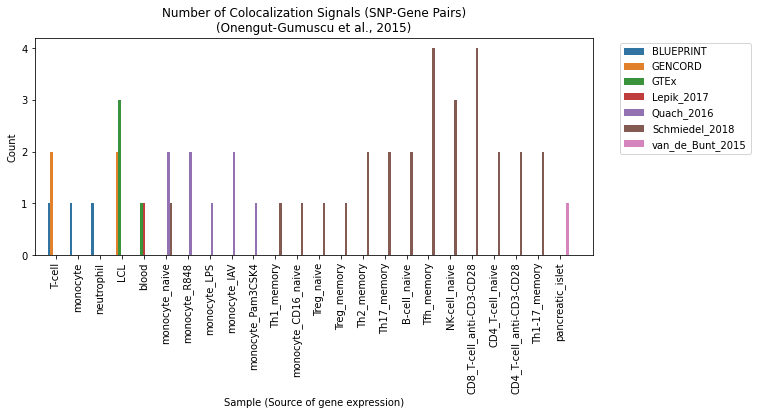

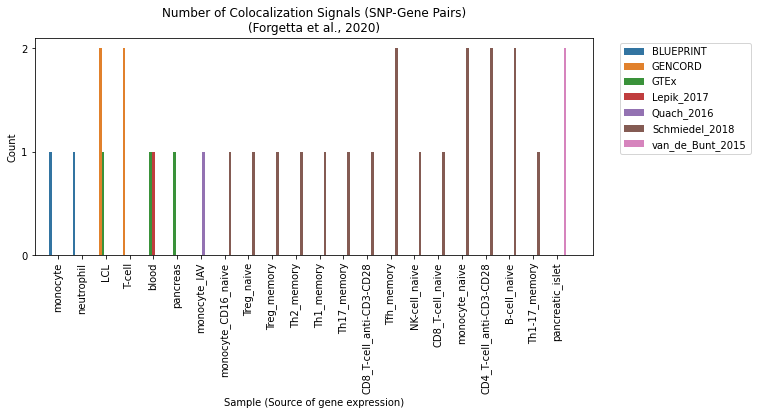

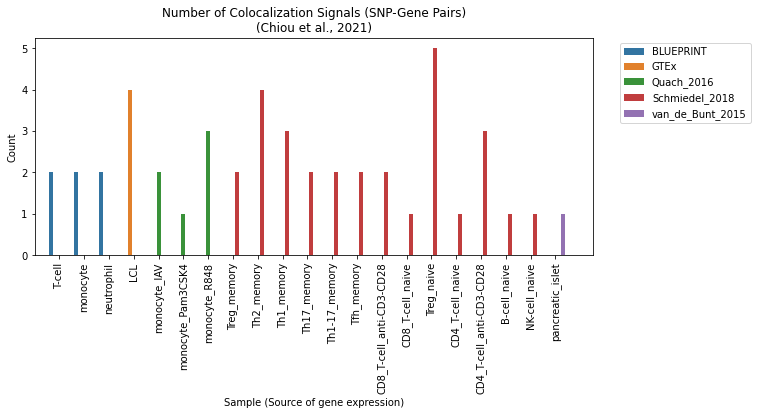

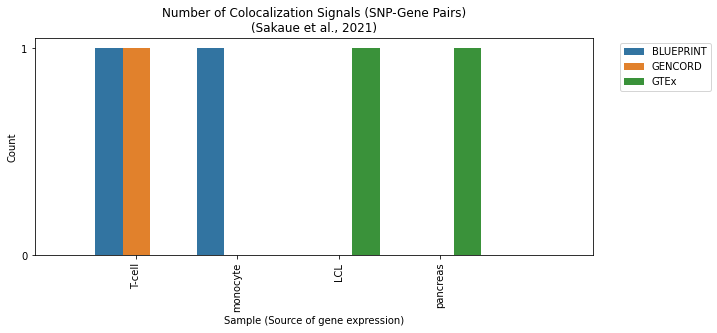

In [16]:
for gwas_source, gwas_summary in study_summary.groupby('gwas_source'):
        
    #sns.barplot(hue='eqtl', y='count', x='ge', data=study_summary)
    fig, ax = plt.subplots(figsize=(10,4))
    
    # Draw a nested barplot by species and sex
    gwas_summary.sort_values('eqtl_source', inplace=True)
    g = sns.barplot(data=gwas_summary,
                x="ge_source", y="count",
                hue='eqtl_source', ax=ax)

    # move the legend
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    
    # rotate the tick marks
    for x in g.get_xticklabels():
        x.set_rotation(90)
        

    gwas_authorship = gwas_meta.loc[gwas_source, 'authorship']
    g.set_title('Number of Colocalization Signals (SNP-Gene Pairs)\n({})'.format(gwas_authorship))
    g.set_xlabel('Sample (Source of gene expression)')
    g.set_ylabel('Count')
    g.set_yticks(list(range(0, max(gwas_summary['count']) + 1)))
    
    # expand the x limits
    ax.set_xlim(-1, gwas_summary.ge_source.nunique() + 0.5)


In [17]:
study_report_fn = os.path.join(outdir, 'coloc_report.tsv')
study_summary.to_csv(study_report_fn, sep='\t', index=False)

## Plotting the Number of Unique Genes per Colocalization Analysis

In [18]:
uniq_genes_per_sample = t1d_data.groupby(['gwas_source', 'eqtl_source', 'ge_source']).genename.nunique()
uniq_genes_per_sample = uniq_genes_per_sample.reset_index()

In [19]:
uniq_genes_per_sample

,gwas_source,eqtl_source,ge_source,genename
0,T1D_25751624,BLUEPRINT,T-cell,1
1,T1D_25751624,BLUEPRINT,monocyte,1
2,T1D_25751624,BLUEPRINT,neutrophil,1
3,T1D_25751624,GENCORD,LCL,2
4,T1D_25751624,GENCORD,T-cell,2
...,...,...,...,...
73,T1D_34594039_GCST90018925,BLUEPRINT,T-cell,1
74,T1D_34594039_GCST90018925,BLUEPRINT,monocyte,1
75,T1D_34594039_GCST90018925,GENCORD,T-cell,1
76,T1D_34594039_GCST90018925,GTEx,LCL,1


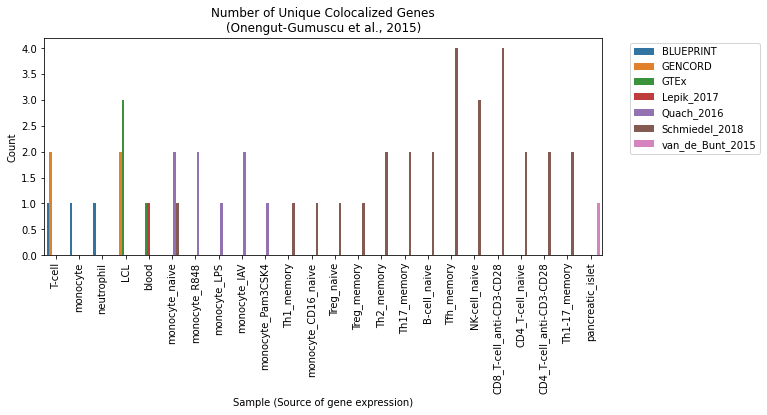

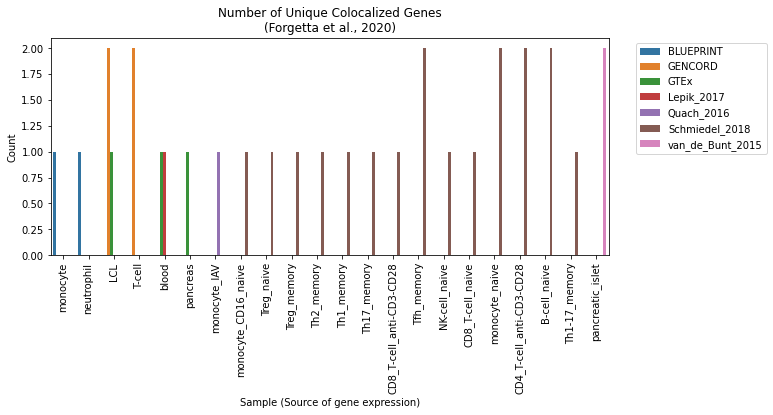

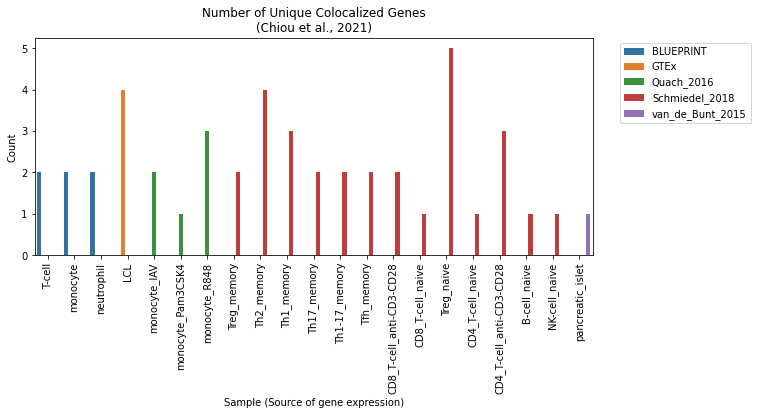

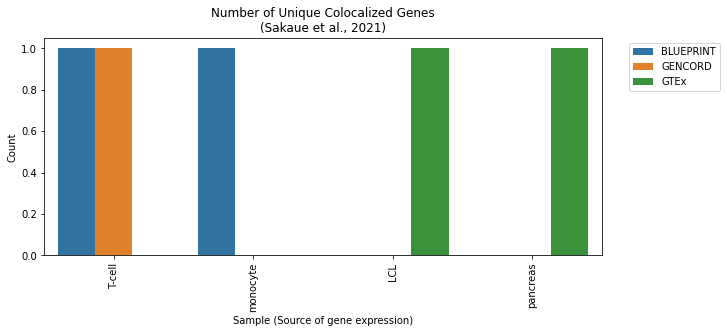

In [20]:
for gwas_source, gwas_summary in uniq_genes_per_sample.groupby('gwas_source'):
        
    fig, ax = plt.subplots(figsize=(10,4))
    
    # Draw a nested barplot by species and sex
    gwas_summary.sort_values('eqtl_source', inplace=True)
    g = sns.barplot(data=gwas_summary,
                x="ge_source", y="genename",
                hue='eqtl_source', ax=ax)

    # move the legend
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    

    for x in g.get_xticklabels():
        x.set_rotation(90)

    gwas_authorship = gwas_meta.loc[gwas_source, 'authorship']    
    g.set_title('Number of Unique Colocalized Genes\n({})'.format(gwas_authorship))
    g.set_xlabel('Sample (Source of gene expression)')
    g.set_ylabel('Count')

In [21]:
# find the uniq snps
uniq_snps_per_samples = t1d_data.groupby(['gwas_source', 'eqtl_source', 'ge_source']).rsid.nunique().reset_index()

### Table for the number of unique genes and snps per colocalization analyses

In [22]:
# concat the two tables
uniq_summary = uniq_genes_per_sample.merge(uniq_snps_per_samples)
uniq_summary.columns = ['gwas', 'eqtl', 'ge', 'Unique # Genes', 'Unique # SNPs']

In [23]:
pd.set_option('display.max_rows', 100) 
display(uniq_summary.sort_values(['gwas', 'Unique # SNPs'], ascending=False))
pd.set_option('display.max_rows', 20) 

,gwas,eqtl,ge,Unique # Genes,Unique # SNPs
73,T1D_34594039_GCST90018925,BLUEPRINT,T-cell,1,1
74,T1D_34594039_GCST90018925,BLUEPRINT,monocyte,1,1
75,T1D_34594039_GCST90018925,GENCORD,T-cell,1,1
76,T1D_34594039_GCST90018925,GTEx,LCL,1,1
77,T1D_34594039_GCST90018925,GTEx,pancreas,1,1
71,T1D_34012112_Gaulton,Schmiedel_2018,Treg_naive,5,5
55,T1D_34012112_Gaulton,GTEx,LCL,4,4
69,T1D_34012112_Gaulton,Schmiedel_2018,Th2_memory,4,4
58,T1D_34012112_Gaulton,Quach_2016,monocyte_R848,3,3
60,T1D_34012112_Gaulton,Schmiedel_2018,CD4_T-cell_anti-CD3-CD28,3,3


## Summarizing the Unique Genes Combined Across all Colocalization Analyses

In [24]:
# construct a table of unique genes 
gene_uniq_summary = t1d_data.drop_duplicates(['gwas_source', 'eqtl_source', 'ge_source', 'genename']).genename.value_counts()
gene_uniq_summary = gene_uniq_summary.to_frame()
gene_uniq_summary.sort_values('genename', ascending=False, inplace=True)
gene_uniq_summary.columns = ['Number of Unique Colocalizations per Gene in ALL Studies']

print('There are {} unique genes in the whole dataset.'.format(gene_uniq_summary.shape[0]))

# display this table
pd.set_option('display.max_rows', gene_uniq_summary.shape[0]) 
display(gene_uniq_summary)
pd.set_option('display.max_rows', 20) 

There are 64 unique genes in the whole dataset.


,Number of Unique Colocalizations per Gene in ALL Studies
RPS26,14
DOK6,12
AC068254.1,7
TMPRSS3,5
GLIS3,4
AL157395.1,3
LINC01031,3
AL132996.1,3
AL137186.1,3
AC008063.1,3


In [25]:
# save an enrichr file 
enrichr_fn = os.path.join(outdir, 'enrichr.input.txt')
with open(enrichr_fn, 'w') as fw:
    for x in sorted(gene_uniq_summary.index.tolist()):
        print(x, file=fw)
        print(x)

AC008063.1
AC008063.2
AC016747.2
AC021205.3
AC027228.1
AC063965.1
AC068254.1
AC091196.1
AC091563.1
ACTA2
AKR1C4
AL096678.1
AL121787.1
AL132996.1
AL133370.1
AL133445.2
AL137186.1
AL137856.1
AL157394.2
AL157395.1
AL157871.5
AL163932.1
AL354760.1
AL354977.2
AL355303.1
AL359317.1
AL513548.4
ANKRD22
AP001610.1
AP005137.2
ASB13
BACH2
BBS12
C11orf21
CACHD1
CBS
CD226
CENPW
CTLA4
DOK6
DPP4
DSCC1
FGF2
GABRR2
GLIS3
HUS1B
IRF4
LINC01031
LINC02285
LINC02320
LINC02561
LIPM
NPIPB15
PRKCQ
PRKCQ-AS1
RGS1
ROR1
RPS26
SLC22A18AS
SOCS6
TFF2
TMPRSS3
TNFRSF11B
TRIM61


## Quick Dive into Treg Naive

In [26]:
treg = t1d_data.loc[t1d_data['ge_source'] == 'Treg_naive', :]
treg.sort_values(['chr', 'pos'], inplace=True)

/mnt/BioHome/jreyna/software/anaconda3/envs/hic_tls/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
treg[major_cols]

,chr,pos,rsid,varid,genename,ppH4,sg_dist,eqtl_pval,eqtl_fdr,eqtl_slope,eqtl_slope_se,gwas_slope,gwas_slope_se,gwas_pval,gwas_sample_size,gwas_source,eqtl_source,ge_source,gene_id
123,chr1,113285485,rs773560,1:113285485:G:A,AL137856.1,0.978083,526894,2.323010e-02,0.632393,-0.438205,0.004354,0.168861,0.015663,4.230000e-27,520580.0,T1D_34012112_Gaulton,Schmiedel_2018,Treg_naive,ENSG00000231128
120,chr1,192546719,rs10801128,1:192546719:A:G,RGS1,0.865499,29044,1.363810e-02,0.541238,0.225144,0.016133,0.096073,0.015681,8.980000e-10,520580.0,T1D_34012112_Gaulton,Schmiedel_2018,Treg_naive,ENSG00000090104
74,chr10,6056861,rs706779,10:6056861:T:C,AL157395.1,0.817264,145832,1.118810e-02,0.506346,0.313304,0.007850,-0.166800,0.023800,2.250000e-12,NaN,T1D_32005708,Schmiedel_2018,Treg_naive,ENSG00000213994
124,chr14,98019683,rs922406,14:98019683:T:C,AL163932.1,0.787636,185460,9.708230e-03,0.481031,-0.493646,0.002879,-0.092793,0.015229,1.110000e-09,520580.0,T1D_34012112_Gaulton,Schmiedel_2018,Treg_naive,ENSG00000259097
45,chr18,69858621,rs3018275,18:69858621:C:T,DOK6,0.842460,457733,1.243620e-07,0.000112,-0.527773,0.002469,0.120978,0.017997,1.789737e-11,NaN,T1D_25751624,Schmiedel_2018,Treg_naive,ENSG00000206052
122,chr18,69858621,rs3018275,18:69858621:C:T,DOK6,0.841050,457733,1.243620e-07,0.000112,-0.527773,0.002469,-0.102841,0.014026,2.260000e-13,520580.0,T1D_34012112_Gaulton,Schmiedel_2018,Treg_naive,ENSG00000206052
121,chr2,60422008,rs12997266,2:60422008:G:A,AC016747.2,0.754330,740097,2.485170e-02,0.643440,-0.368777,0.009128,-0.087489,0.014351,1.090000e-09,520580.0,T1D_34012112_Gaulton,Schmiedel_2018,Treg_naive,ENSG00000271889


## Quick Dive into GLIS3

Very lowly expressed according to DICE: https://dice-database.org/genes/GLIS3 and eQTL FDR is not significant. 

In [28]:
t1d_data.loc[t1d_data['genename'] == 'GLIS3', major_cols]

,chr,pos,rsid,varid,genename,ppH4,sg_dist,eqtl_pval,eqtl_fdr,eqtl_slope,eqtl_slope_se,gwas_slope,gwas_slope_se,gwas_pval,gwas_sample_size,gwas_source,eqtl_source,ge_source,gene_id
84,chr9,4290823,rs6476839,9:4290823:A:T,GLIS3,0.809271,57569,0.010269,0.242092,-0.338403,0.006585,0.123270,0.014153,3.040000e-18,520580.0,T1D_34012112_Gaulton,BLUEPRINT,neutrophil,ENSG00000107249
90,chr9,4296430,rs10814917,9:4296430:A:G,GLIS3,0.759110,51962,0.057347,0.713889,-0.274822,0.012701,-0.119714,0.013994,1.180000e-17,520580.0,T1D_34012112_Gaulton,Quach_2016,monocyte_IAV,ENSG00000107249
92,chr9,4296430,rs10814917,9:4296430:A:G,GLIS3,0.776345,51962,0.027644,0.568634,-0.325938,0.008901,-0.119714,0.013994,1.180000e-17,520580.0,T1D_34012112_Gaulton,Quach_2016,monocyte_Pam3CSK4,ENSG00000107249
95,chr9,4282536,rs4380994,9:4282536:A:G,GLIS3,0.806803,65856,0.006440,0.336787,-0.407677,0.005361,-0.121582,0.013995,3.710000e-18,520580.0,T1D_34012112_Gaulton,Quach_2016,monocyte_R848,ENSG00000107249
